In [1]:

import numpy as np

from collections import defaultdict
import copy

import sys
import os
import time
import datetime
import torch
import torchvision

import matplotlib.pyplot as plt
import torch.nn as nn



ModuleNotFoundError: No module named 'torch'

In [2]:
import sys
sys.path.append('/home/nbuser/demo/poison/ASPARaGUS')

In [3]:
from forest.victims.models import get_model
from forest.victims.models import resnet_picker
#from forest.victims.training import get_optimizers
#from forest.hyperparameters import training_strategy

#from ..utils import set_random_seed
#from ..consts import BENCHMARK
#torch.backe.nds.cudnn.benchmark = BENCHMARK

#from .victim_base import _VictimBase

In [4]:
#model = resnet_picker('ResNet18', 'CIFAR10')
#model.load_state_dict(torch.load("/home/nbuser/demo/poison/models/clean_model/full_epoch_30.pth"))
model = get_model('ResNet18', 'CIFAR10', load_model="/home/nbuser/demo/poison/models/clean_model/full_epoch_30.pth")
model


/home/nbuser/demo/poison/ASPARaGUS/forest/victims/models.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(load_model)['state_dict']


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [5]:
device ='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [8]:
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [9]:
X_train = np.array(trainset.data)
y_train = np.array(trainset.targets)
X_test = np.array(testset.data)
y_test = np.array(testset.targets)

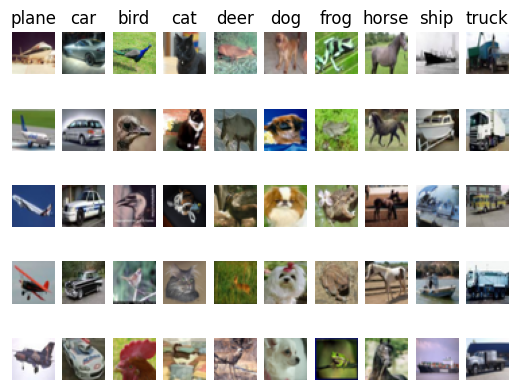

In [10]:
num_classes = len(classes)
samples_per_class = 5
for y, label in enumerate(classes):
    in_class_ids = np.flatnonzero(y_train == y)
    in_class_ids = np.random.choice(in_class_ids, samples_per_class, replace=False)
    for i, idx in enumerate(in_class_ids):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(label)
plt.show()

In [13]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layers): Sequential(
    (0): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3,

In [14]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.000125)
criterion = nn.CrossEntropyLoss()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [15]:

dataloader = testloader
correct_number = 0
for data, targets in dataloader: 
    data = data.to(device)
    targets = targets.to(device)
#    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        outputs = model(data)
        loss = criterion(outputs, targets)
        _, preds = torch.max(outputs, 1)
                    
    loss += loss.item() * data.size(0)
    correct_number += torch.sum(preds == targets.data)

epoch_loss = loss / len(dataloader.dataset)
epoch_accuracy = correct_number.double() / len(dataloader.dataset)
print('loss = {:.4f} accuracy = {:.4f}'.format(epoch_loss, epoch_accuracy))


loss = 0.0000 accuracy = 0.8533


In [16]:
outputs

tensor([[-2.0321, -6.6890,  1.2232,  8.1826,  1.8143,  1.8404,  2.8780, -2.3608,
         -2.0693, -2.7670],
        [-0.6138, -3.8287,  0.6159,  0.9706, -0.4090,  8.3781, -1.0560, -2.1904,
         -1.6275, -0.2740],
        [ 1.0831, 10.4229,  1.2270, -2.7538, -1.5867, -4.5143, -0.4170, -4.6558,
          0.5075,  0.6845],
        [ 0.1649, -1.7869, -1.4604, -1.6345,  0.4660, -2.6178, -2.9218,  9.3078,
         -0.0868,  0.5709]], device='cuda:0')

In [17]:
num_epochs=5
dataloader = trainloader
for epoch in range(num_epochs):
    print('epoch = {}'.format(epoch))
    loss = 0.0
    correct_number = 0

    for data, targets in dataloader: 
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            outputs = model(data)
            loss = criterion(outputs, targets)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
                    
        loss += loss.item() * data.size(0)
        correct_number += torch.sum(preds == targets.data)
        
    epoch_loss = loss / len(dataloader.dataset)
    epoch_accuracy = correct_number.double() / len(dataloader.dataset)
    print('loss = {:.4f} accuracy = {:.4f}'.format(epoch_loss, epoch_accuracy))


epoch = 0
loss = 0.0000 accuracy = 0.6958
epoch = 1
loss = 0.0001 accuracy = 0.8303
epoch = 2
loss = 0.0000 accuracy = 0.8652
epoch = 3
loss = 0.0000 accuracy = 0.8877
epoch = 4
loss = 0.0000 accuracy = 0.9031
